In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(50, 79069)

In [4]:
data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['ender_a1_v3.1_10yrs'], data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['baseline_v3.0_10yrs']

(204.0, 200.0)

In [5]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Gaps' in col and '18k' in col]

['Mean N gaps in g at 24hr in top 18k Gaps_24hr g band HealpixSlicer',
 'Mean N gaps in g at 3hr in top 18k Gaps_3hr g band HealpixSlicer',
 'Mean N gaps in g at 7hr in top 18k Gaps_7hr g band HealpixSlicer',
 'Mean N gaps in i at 24hr in top 18k Gaps_24hr i band HealpixSlicer',
 'Mean N gaps in i at 3hr in top 18k Gaps_3hr i band HealpixSlicer',
 'Mean N gaps in i at 7hr in top 18k Gaps_7hr i band HealpixSlicer',
 'Mean N gaps in r at 24hr in top 18k Gaps_24hr r band HealpixSlicer',
 'Mean N gaps in r at 3hr in top 18k Gaps_3hr r band HealpixSlicer',
 'Mean N gaps in r at 7hr in top 18k Gaps_7hr r band HealpixSlicer',
 'Mean N gaps in u at 24hr in top 18k Gaps_24hr u band HealpixSlicer',
 'Mean N gaps in u at 3hr in top 18k Gaps_3hr u band HealpixSlicer',
 'Mean N gaps in u at 7hr in top 18k Gaps_7hr u band HealpixSlicer',
 'Mean N gaps in y at 24hr in top 18k Gaps_24hr y band HealpixSlicer',
 'Mean N gaps in y at 3hr in top 18k Gaps_3hr y band HealpixSlicer',
 'Mean N gaps in y at 7h

In [6]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'FF u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'FF g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'FF r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'FF i',
    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
             'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            #}
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'FF u': '',
         'FF g': '',
         'FF r': '',
         'FF i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [7]:
#data['KNe single model'] # data['KNe ZTF simple']

In [8]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [9]:
mag_data

,g,i,r,u,y,z
baseline_v2.0_10yrs,26.733479,26.218659,26.755971,25.818916,24.762720,25.510379
baseline_v2.1_10yrs,26.736248,26.252054,26.781543,25.751969,24.728145,25.486640
baseline_v2.2_10yrs,26.753646,26.290929,26.835430,25.724699,24.782743,25.581317
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
baseline_v3.2_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586
ddf_loaded_fl15_v3.2_10yrs,26.678676,26.281373,26.807344,25.625748,24.773055,25.567216
ddf_loaded_fl1_v3.2_10yrs,26.711369,26.308950,26.823432,25.641165,24.793886,25.594354
ddf_loaded_fl2_v3.2_10yrs,26.705791,26.301228,26.823345,25.633329,24.786643,25.579746
ddf_loaded_fl4_v3.2_10yrs,26.687342,26.293076,26.816467,25.631489,24.780471,25.575256
ddf_loaded_fl8_v3.2_10yrs,26.691789,26.291687,26.813812,25.622986,24.769974,25.581066


In [10]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS,...,Kne EDFS,Kne ELAISS1,Kne WFD,Kne XMM_LSS,N COSMOS,N ECDFS,N EDFS,N ELAISS1,N WFD,N XMM_LSS
baseline_v2.0_10yrs,638.253284,586.826209,974.231557,684.401547,611.229060,0.503926,0.485978,0.481621,0.508870,0.490990,...,470.0,427.0,337.0,415.0,8937.5,9264.0,5497.0,9262.0,833.0,9024.0
baseline_v2.1_10yrs,548.479625,545.669910,875.981802,636.634918,520.071105,0.496150,0.484905,0.474738,0.501027,0.480094,...,444.0,392.0,302.0,404.0,8900.0,9166.5,5506.0,9127.0,820.0,8941.0
baseline_v2.2_10yrs,708.239238,685.202422,1067.553931,674.561648,611.247120,0.493897,0.495572,0.466223,0.488264,0.484132,...,530.0,418.0,339.0,403.0,9853.0,9663.0,6150.0,9991.0,829.0,9869.0
baseline_v3.0_10yrs,955.159293,799.584601,1266.961769,688.808879,726.491723,0.503734,0.521961,0.464010,0.500330,0.484669,...,539.0,433.0,365.0,363.0,18716.5,10606.5,6668.0,10671.0,817.0,10845.0
baseline_v3.2_10yrs,1011.289811,944.550157,1645.116982,947.994960,947.530373,0.513325,0.543603,0.488181,0.517872,0.503619,...,426.0,357.0,293.0,321.0,20610.5,11398.5,7135.0,10819.0,854.0,11121.0
ddf_loaded_fl15_v3.2_10yrs,1207.725886,1162.228558,1795.903515,1179.832171,1185.359093,0.509665,0.539003,0.483732,0.506998,0.501926,...,455.0,366.0,279.0,338.0,22910.5,12325.5,7716.0,12149.0,858.0,12057.0
ddf_loaded_fl1_v3.2_10yrs,855.022585,746.618134,1230.525963,702.908893,665.735100,0.474513,0.502615,0.453937,0.481395,0.457043,...,432.0,342.0,325.0,334.0,12314.0,6643.5,4593.0,6572.0,882.0,6493.0
ddf_loaded_fl2_v3.2_10yrs,984.755871,920.519136,1565.182545,938.242736,900.698188,0.498240,0.510592,0.467251,0.487281,0.482197,...,459.0,341.0,293.0,345.0,15364.5,8581.0,5764.0,8391.0,882.0,8266.0
ddf_loaded_fl4_v3.2_10yrs,1094.948800,1085.830999,1656.810011,1078.586017,1036.653687,0.512407,0.520392,0.471622,0.508424,0.485551,...,465.0,333.0,303.0,349.0,18642.5,10238.5,6603.0,9977.0,859.0,9908.0
ddf_loaded_fl8_v3.2_10yrs,1174.434509,1127.409502,1746.039414,1168.729157,1154.329317,0.510055,0.525981,0.480336,0.513658,0.499803,...,444.0,354.0,307.0,359.0,21191.5,11528.0,7358.0,11270.0,856.0,11326.0


In [11]:
gaps_data

,gaps u 3,gaps u 7,gaps u 24,gaps g 3,gaps g 7,gaps g 24,gaps r 3,gaps r 7,gaps r 24,gaps i 3,gaps i 7,gaps i 24,gaps z 3,gaps z 7,gaps z 24,gaps y 3,gaps y 7,gaps y 24
baseline_v2.0_10yrs,0.559565,0.096983,2.681121,0.501515,0.060381,4.151443,2.579755,0.452371,17.055252,2.086213,0.422810,15.289504,2.832937,0.465706,18.134005,2.181890,0.218119,10.919662
baseline_v2.1_10yrs,0.601110,0.097077,2.961440,0.621392,0.080291,4.104024,2.708024,0.389565,18.103231,2.217187,0.366019,16.026064,3.008206,0.484776,18.327179,2.477409,0.206229,10.257798
baseline_v2.2_10yrs,0.633655,0.187066,3.622465,0.399776,0.051569,4.466172,1.834849,0.314636,19.672775,1.433580,0.276449,16.984520,2.238075,0.408775,20.773395,1.377629,0.186833,8.640323
baseline_v3.0_10yrs,0.257192,0.257425,3.984706,0.213736,0.363687,3.787056,1.069054,1.779876,20.989882,1.293328,1.973516,18.047932,1.569590,1.366578,22.387886,0.725976,0.211312,9.392083
baseline_v3.2_10yrs,0.112463,0.082296,2.881196,0.656968,0.643587,3.741829,1.265492,0.838486,20.547256,1.913088,1.332447,18.523383,1.256959,0.651700,17.077773,0.936868,0.389472,11.155313
ddf_loaded_fl15_v3.2_10yrs,0.156805,0.088078,3.025831,0.745699,0.704434,3.526600,1.188325,0.791253,20.552525,1.920921,1.241386,18.762205,1.141045,0.693477,16.522171,1.013708,0.401595,11.211218
ddf_loaded_fl1_v3.2_10yrs,0.143377,0.067236,2.920688,0.818949,0.596494,3.828228,1.207908,0.822959,21.906374,1.968714,1.334546,19.641582,1.377116,0.894158,18.214156,1.058516,0.401548,11.506131
ddf_loaded_fl2_v3.2_10yrs,0.140952,0.111018,3.176715,0.776472,0.657388,3.948245,1.199515,0.803143,21.829393,2.230475,1.296685,20.039866,1.262601,0.784539,17.719308,1.214575,0.485476,11.321071
ddf_loaded_fl4_v3.2_10yrs,0.146594,0.061920,2.974822,0.778617,0.680748,3.554903,1.203478,0.747331,20.828601,2.000373,1.443698,19.317667,1.286380,0.827109,17.518161,0.966755,0.432228,11.412086
ddf_loaded_fl8_v3.2_10yrs,0.141139,0.081503,2.754931,0.762484,0.746538,3.729379,1.146687,0.737166,20.735814,1.999813,1.308341,18.930480,1.105096,0.758195,16.828834,1.010911,0.361589,11.286147


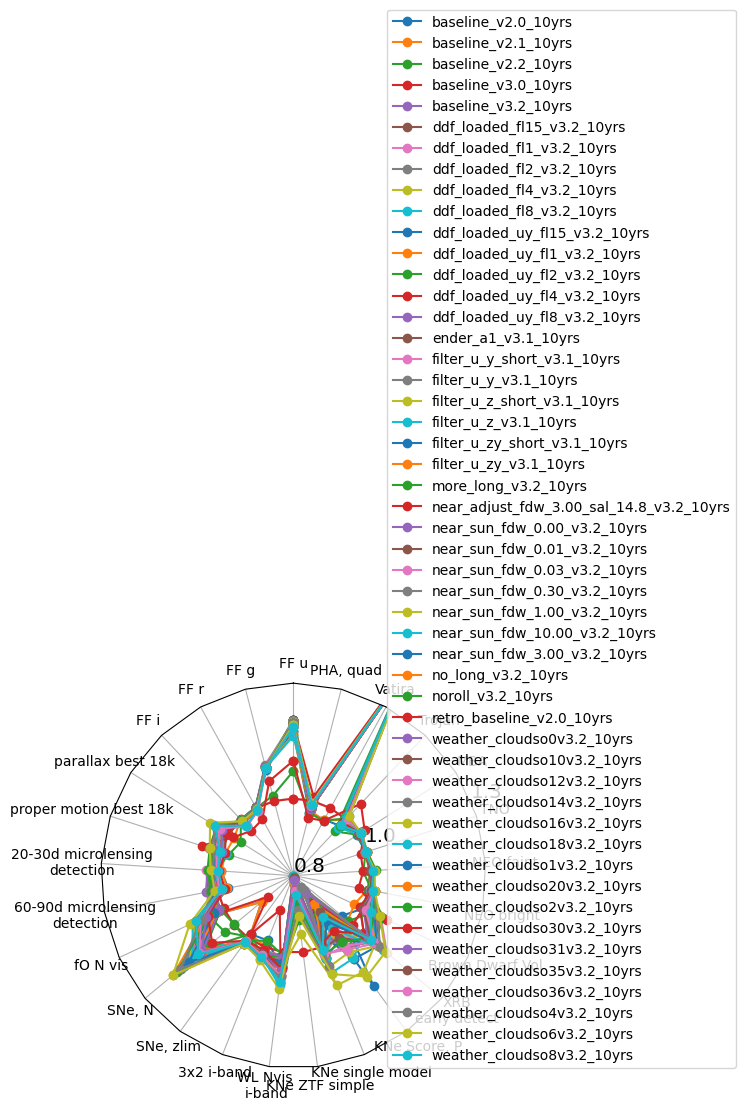

In [12]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

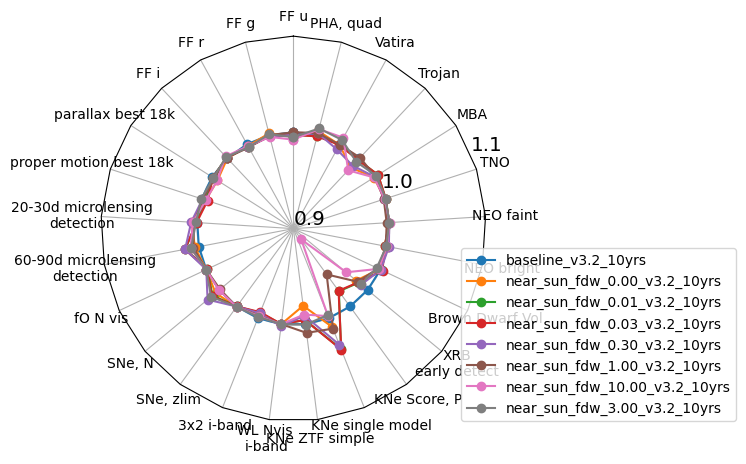

In [13]:
# near sun
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'near_sun' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

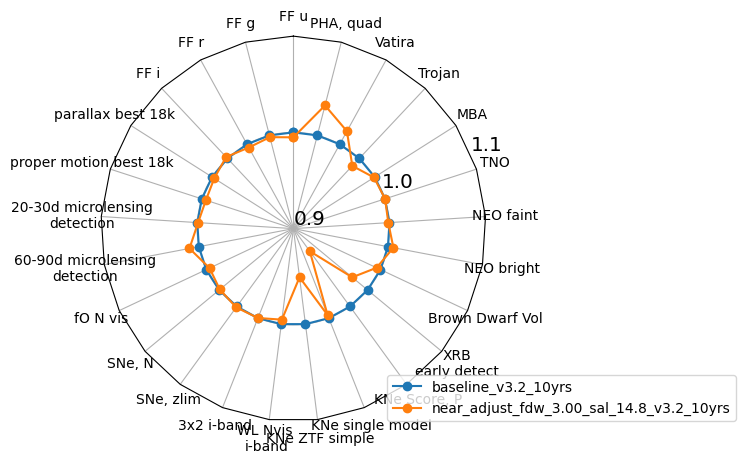

In [14]:
# near sun
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'near_a' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

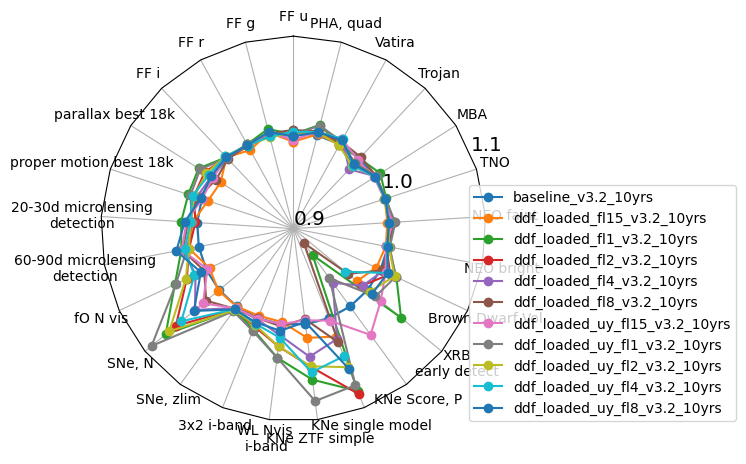

In [15]:
# DDF loaded
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf_loaded' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [16]:
data.loc[runs]

,FF u,FF g,FF r,FF i,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
baseline_v3.2_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906
ddf_loaded_fl15_v3.2_10yrs,0.968052,0.984558,0.990241,0.997282,0.790333,0.186657,0.3390,0.4738,802.0,121144.624536,...,198.151853,2050.0,172613.100577,0.9370,0.639896,0.720664,0.928061,0.592901,0.4444,0.870982
ddf_loaded_fl1_v3.2_10yrs,0.975725,0.988388,0.996912,0.997406,0.769227,0.182717,0.3509,0.4819,834.0,129746.226638,...,219.775194,2174.0,176594.558009,0.9398,0.646860,0.722269,0.932525,0.598572,0.4435,0.879742
ddf_loaded_fl2_v3.2_10yrs,0.975586,0.982088,0.994441,0.997159,0.774900,0.183839,0.3361,0.4737,823.0,128081.654114,...,208.342076,2065.0,175371.156372,0.9376,0.642966,0.721081,0.927475,0.588752,0.4433,0.874793
ddf_loaded_fl4_v3.2_10yrs,0.974051,0.981841,0.996294,0.997529,0.781309,0.184379,0.3443,0.4799,815.0,124952.022849,...,228.139881,2066.0,173966.284177,0.9394,0.642060,0.721374,0.926962,0.582935,0.4504,0.872161
ddf_loaded_fl8_v3.2_10yrs,0.980050,0.983817,0.995553,0.995059,0.785855,0.184669,0.3438,0.4811,807.0,123132.534842,...,216.140728,2025.0,173800.292657,0.9396,0.646505,0.720061,0.927445,0.600466,0.4477,0.873462
ddf_loaded_uy_fl15_v3.2_10yrs,0.970006,0.984311,0.995676,0.997900,0.783132,0.185422,0.3454,0.4814,804.0,123645.215052,...,243.903272,2117.0,174455.953758,0.9372,0.645489,0.720402,0.924803,0.596261,0.4502,0.873399
ddf_loaded_uy_fl1_v3.2_10yrs,0.975028,0.984682,0.997035,0.996665,0.770716,0.183140,0.3397,0.4759,833.0,132052.414165,...,226.748597,2102.0,176465.561037,0.9412,0.648225,0.721185,0.927827,0.591415,0.4482,0.878983
ddf_loaded_uy_fl2_v3.2_10yrs,0.977260,0.979741,0.995800,0.999012,0.776599,0.183878,0.3414,0.4738,824.0,129175.565108,...,204.002533,2086.0,176232.760573,0.9402,0.641438,0.720363,0.926488,0.587573,0.4432,0.872677
ddf_loaded_uy_fl4_v3.2_10yrs,0.978237,0.980605,0.995553,0.998765,0.778945,0.183556,0.3413,0.4785,816.0,127194.519921,...,201.038063,2018.0,174887.098842,0.9382,0.641713,0.721233,0.925910,0.588349,0.4511,0.872841


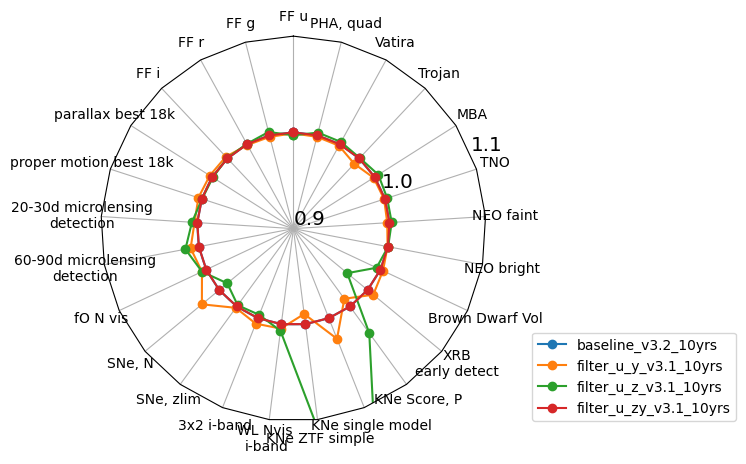

In [17]:
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'filter_u' in run and 'short' not in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [18]:
data.loc[runs]

,FF u,FF g,FF r,FF i,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
baseline_v3.2_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906
filter_u_y_v3.1_10yrs,0.976562,0.980235,0.996170,0.998147,0.779844,0.184722,0.3370,0.4721,809.0,123834.701059,...,232.980919,2096.0,173930.909299,0.9388,0.639774,0.720008,0.924147,0.590819,0.4428,0.868568
filter_u_z_v3.1_10yrs,0.974609,0.985300,0.997529,0.996170,0.782747,0.185466,0.3397,0.4776,809.0,119696.080162,...,243.348206,2023.0,172644.548557,0.9394,0.644416,0.723349,0.930032,0.599102,0.4472,0.872526
filter_u_zy_v3.1_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906


In [19]:
data['Vatira']

baseline_v2.0_10yrs                         0.0039
baseline_v2.1_10yrs                         0.0017
baseline_v2.2_10yrs                         0.0008
baseline_v3.0_10yrs                         0.0376
baseline_v3.2_10yrs                         0.4445
ddf_loaded_fl15_v3.2_10yrs                  0.4444
ddf_loaded_fl1_v3.2_10yrs                   0.4435
ddf_loaded_fl2_v3.2_10yrs                   0.4433
ddf_loaded_fl4_v3.2_10yrs                   0.4504
ddf_loaded_fl8_v3.2_10yrs                   0.4477
ddf_loaded_uy_fl15_v3.2_10yrs               0.4502
ddf_loaded_uy_fl1_v3.2_10yrs                0.4482
ddf_loaded_uy_fl2_v3.2_10yrs                0.4432
ddf_loaded_uy_fl4_v3.2_10yrs                0.4511
ddf_loaded_uy_fl8_v3.2_10yrs                0.4493
ender_a1_v3.1_10yrs                         0.4445
filter_u_y_short_v3.1_10yrs                 0.4477
filter_u_y_v3.1_10yrs                       0.4428
filter_u_z_short_v3.1_10yrs                 0.4463
filter_u_z_v3.1_10yrs          

In [20]:
ddf_data

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS,...,Kne EDFS,Kne ELAISS1,Kne WFD,Kne XMM_LSS,N COSMOS,N ECDFS,N EDFS,N ELAISS1,N WFD,N XMM_LSS
baseline_v2.0_10yrs,638.253284,586.826209,974.231557,684.401547,611.229060,0.503926,0.485978,0.481621,0.508870,0.490990,...,470.0,427.0,337.0,415.0,8937.5,9264.0,5497.0,9262.0,833.0,9024.0
baseline_v2.1_10yrs,548.479625,545.669910,875.981802,636.634918,520.071105,0.496150,0.484905,0.474738,0.501027,0.480094,...,444.0,392.0,302.0,404.0,8900.0,9166.5,5506.0,9127.0,820.0,8941.0
baseline_v2.2_10yrs,708.239238,685.202422,1067.553931,674.561648,611.247120,0.493897,0.495572,0.466223,0.488264,0.484132,...,530.0,418.0,339.0,403.0,9853.0,9663.0,6150.0,9991.0,829.0,9869.0
baseline_v3.0_10yrs,955.159293,799.584601,1266.961769,688.808879,726.491723,0.503734,0.521961,0.464010,0.500330,0.484669,...,539.0,433.0,365.0,363.0,18716.5,10606.5,6668.0,10671.0,817.0,10845.0
baseline_v3.2_10yrs,1011.289811,944.550157,1645.116982,947.994960,947.530373,0.513325,0.543603,0.488181,0.517872,0.503619,...,426.0,357.0,293.0,321.0,20610.5,11398.5,7135.0,10819.0,854.0,11121.0
ddf_loaded_fl15_v3.2_10yrs,1207.725886,1162.228558,1795.903515,1179.832171,1185.359093,0.509665,0.539003,0.483732,0.506998,0.501926,...,455.0,366.0,279.0,338.0,22910.5,12325.5,7716.0,12149.0,858.0,12057.0
ddf_loaded_fl1_v3.2_10yrs,855.022585,746.618134,1230.525963,702.908893,665.735100,0.474513,0.502615,0.453937,0.481395,0.457043,...,432.0,342.0,325.0,334.0,12314.0,6643.5,4593.0,6572.0,882.0,6493.0
ddf_loaded_fl2_v3.2_10yrs,984.755871,920.519136,1565.182545,938.242736,900.698188,0.498240,0.510592,0.467251,0.487281,0.482197,...,459.0,341.0,293.0,345.0,15364.5,8581.0,5764.0,8391.0,882.0,8266.0
ddf_loaded_fl4_v3.2_10yrs,1094.948800,1085.830999,1656.810011,1078.586017,1036.653687,0.512407,0.520392,0.471622,0.508424,0.485551,...,465.0,333.0,303.0,349.0,18642.5,10238.5,6603.0,9977.0,859.0,9908.0
ddf_loaded_fl8_v3.2_10yrs,1174.434509,1127.409502,1746.039414,1168.729157,1154.329317,0.510055,0.525981,0.480336,0.513658,0.499803,...,444.0,354.0,307.0,359.0,21191.5,11528.0,7358.0,11270.0,856.0,11326.0


In [21]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



,FF u,FF g,FF r,FF i,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
retro_baseline_v2.0_10yrs,0.893276,0.949104,0.960964,0.958616,0.804328,0.176701,0.0883,0.1533,848.0,97124.012102,...,202.730488,720.0,179640.718155,0.9048,0.623933,0.705953,0.943433,0.667158,0.0000,0.847880
baseline_v2.0_10yrs,0.955776,0.981594,0.994441,0.997035,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,...,263.696398,1879.0,168086.074111,0.9294,0.642021,0.719635,0.918999,0.588087,0.0039,0.859238
baseline_v2.1_10yrs,0.948661,0.984188,0.996912,0.999012,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,...,243.713720,1918.0,163815.013503,0.9286,0.647553,0.723197,0.927567,0.608979,0.0017,0.865438
baseline_v2.2_10yrs,0.871233,0.914268,0.993947,0.998023,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,...,242.377184,1920.0,172453.127988,0.9304,0.657462,0.723899,0.933507,0.615249,0.0008,0.858538
baseline_v3.0_10yrs,0.813058,0.901174,0.993823,0.999135,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,...,228.428876,1950.0,168032.537231,0.9326,0.642155,0.722293,0.924156,0.611053,0.0376,0.887938
baseline_v3.2_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_11046/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


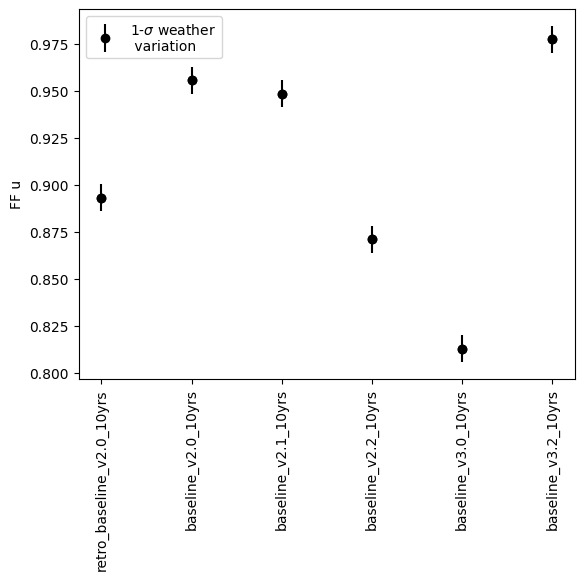

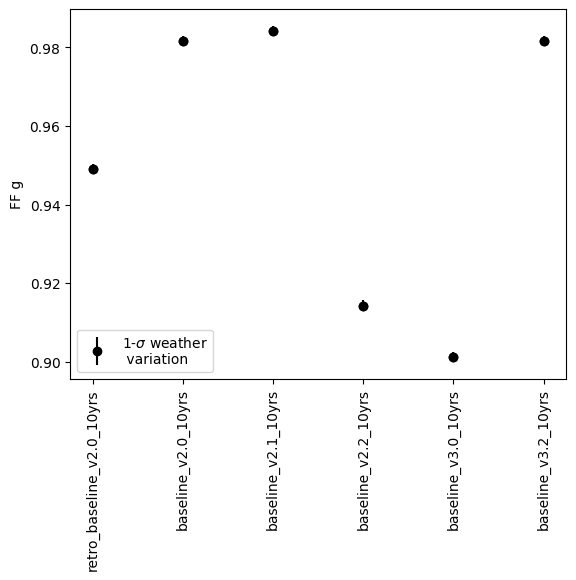

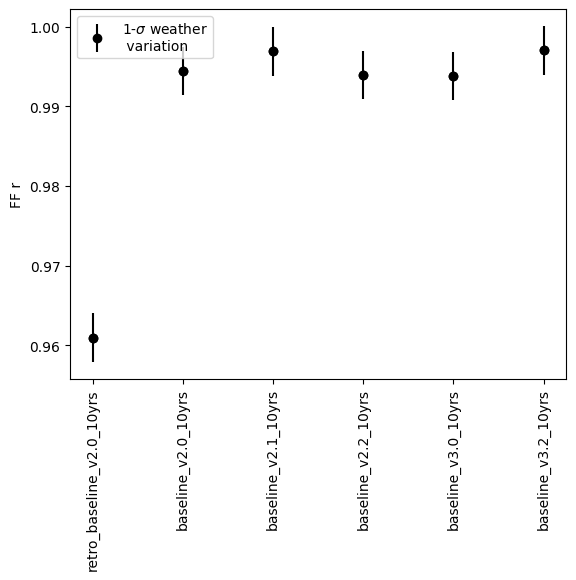

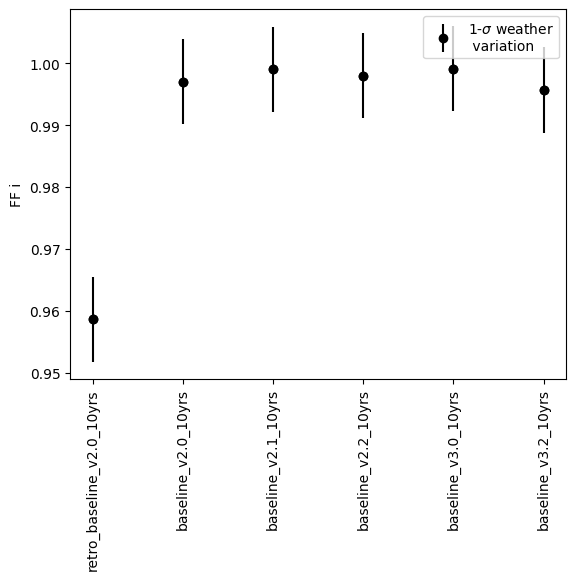

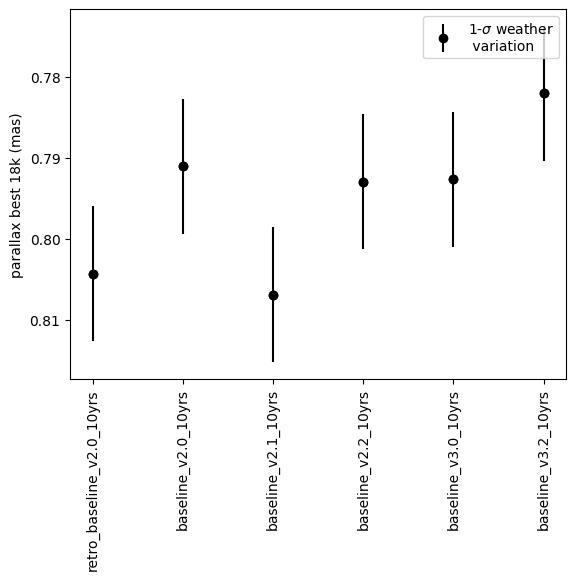

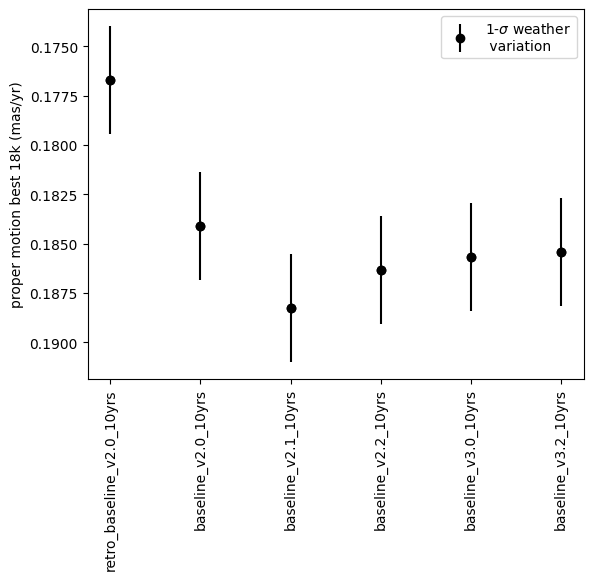

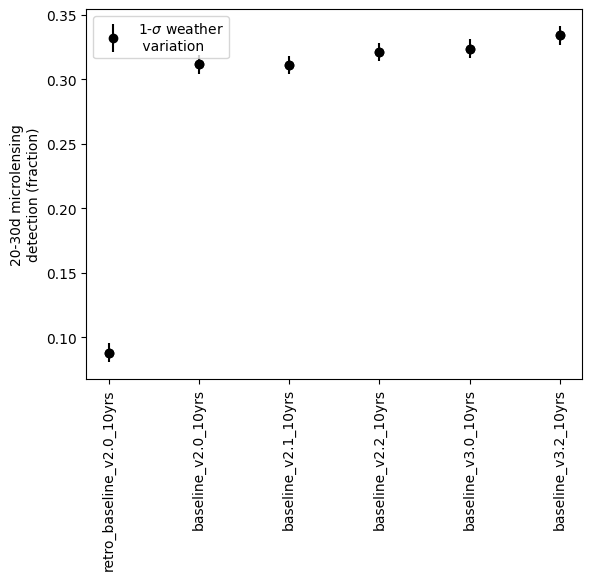

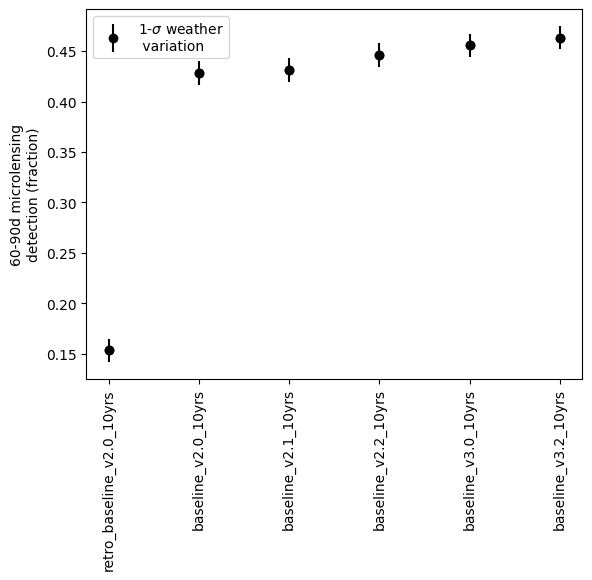

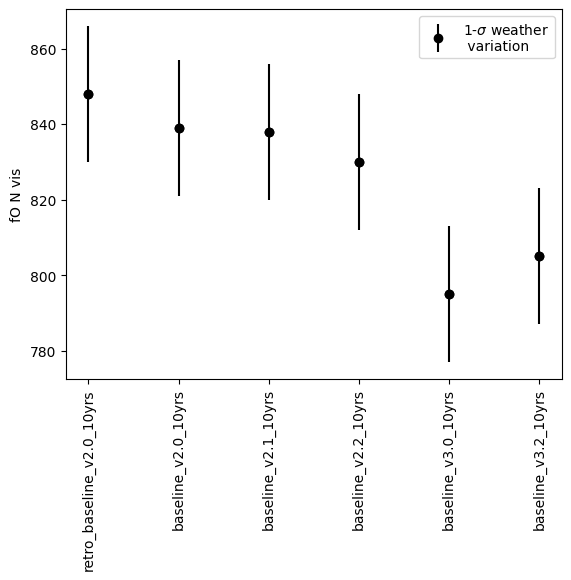

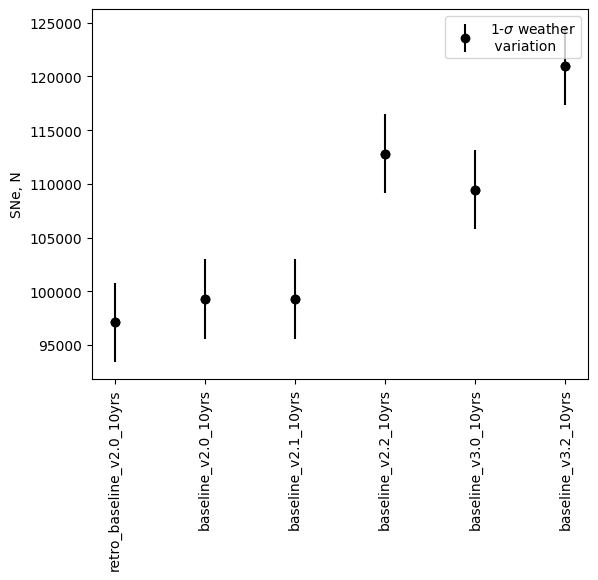

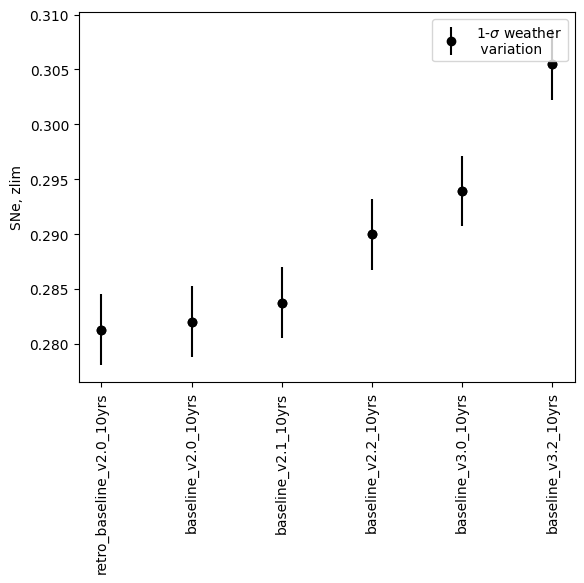

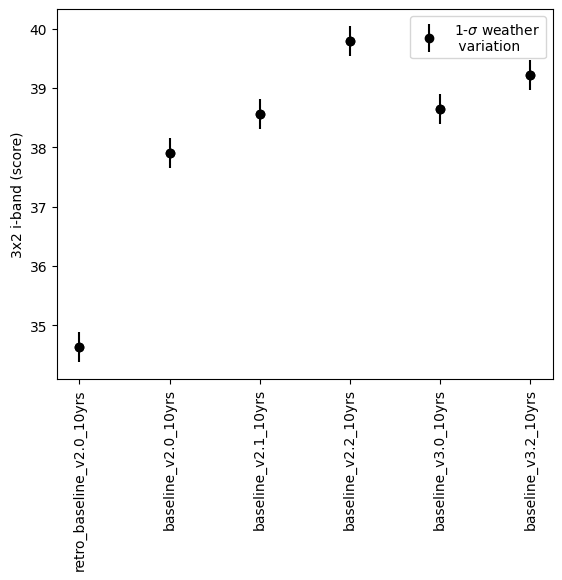

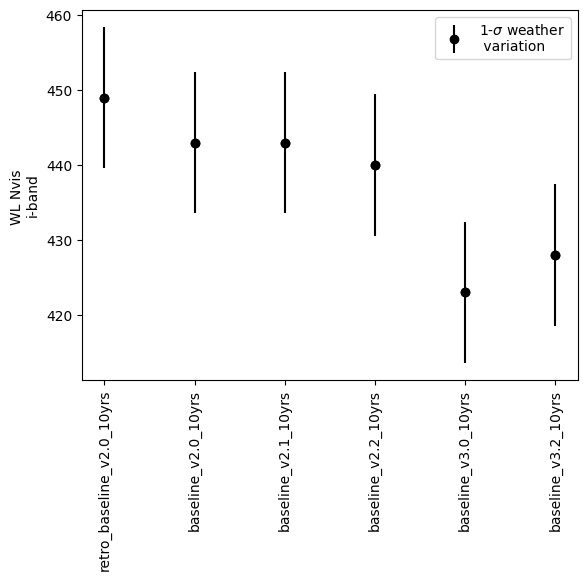

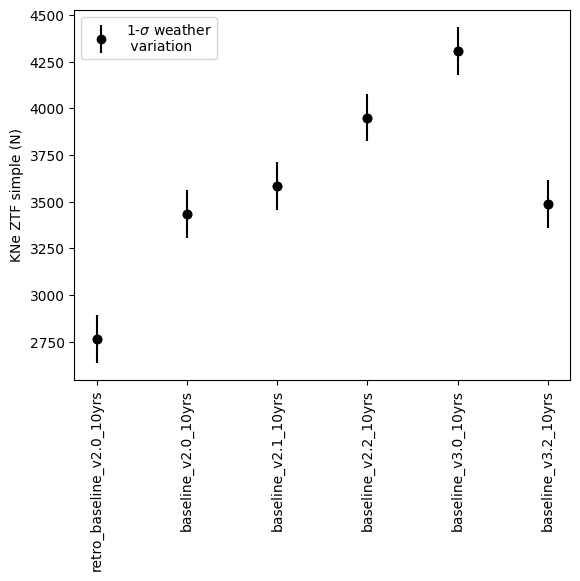

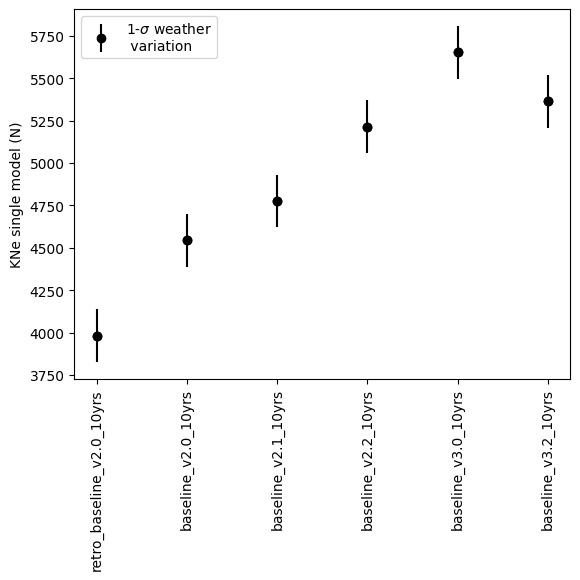

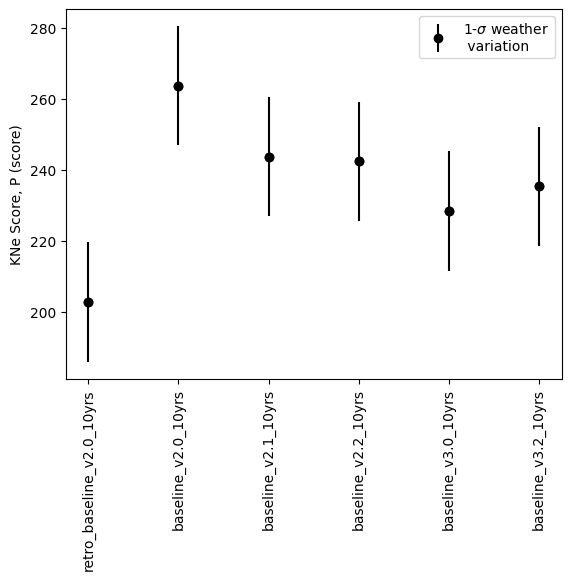

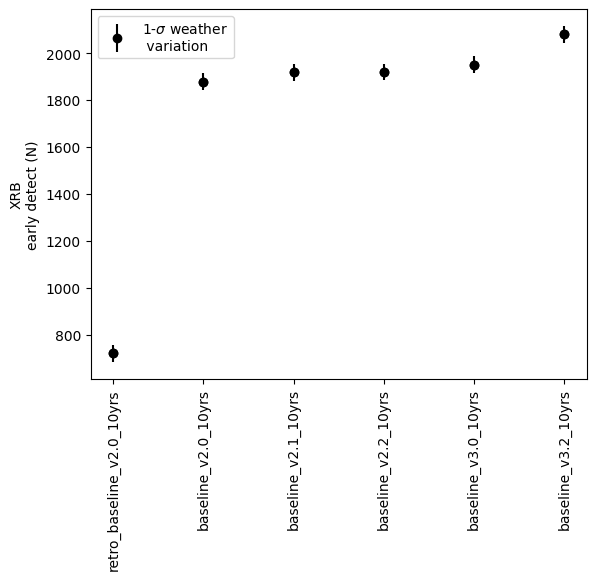

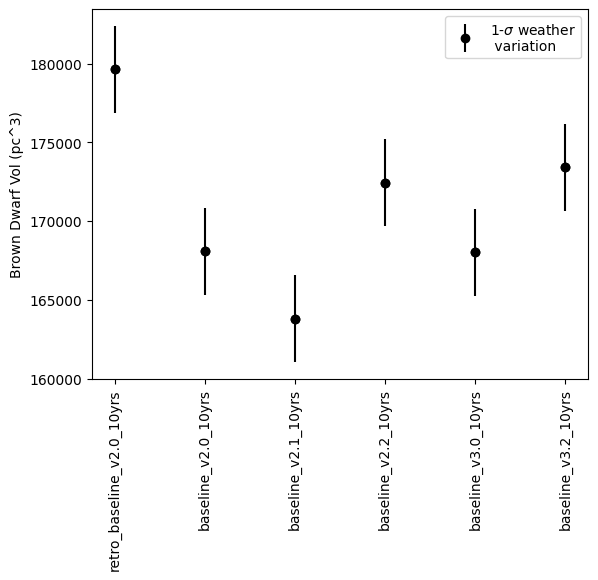

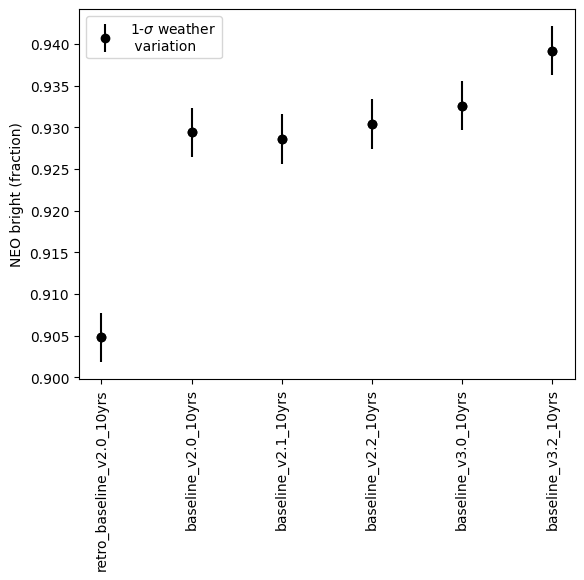

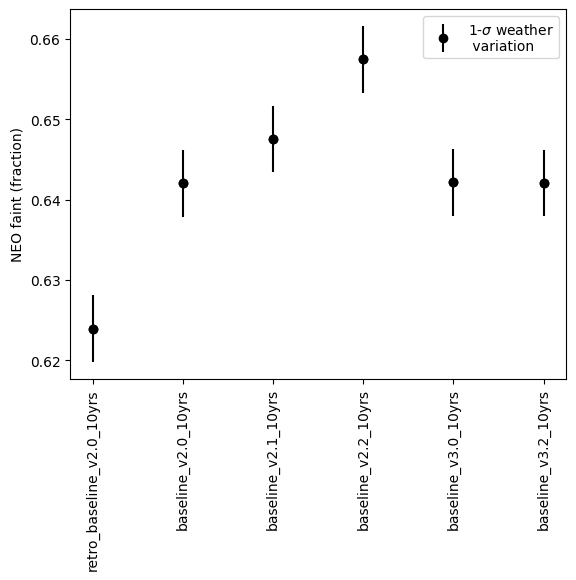

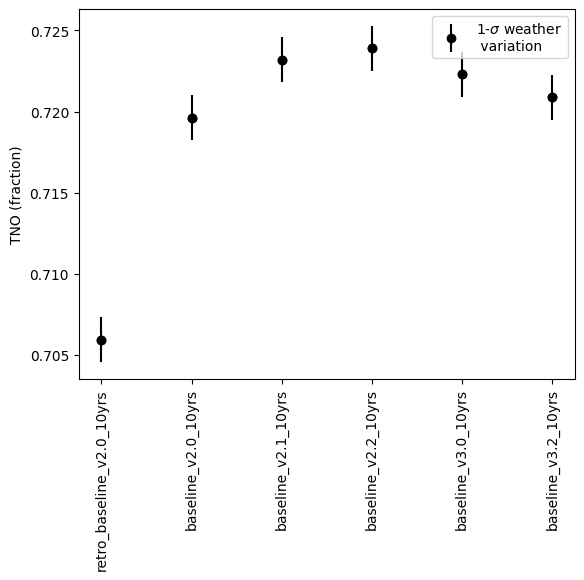

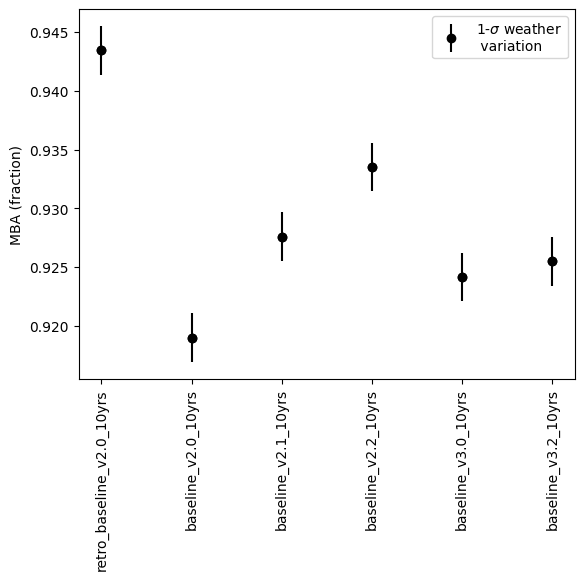

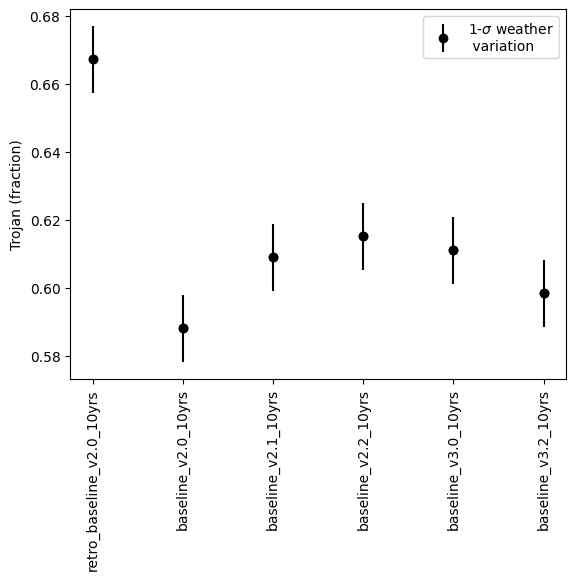

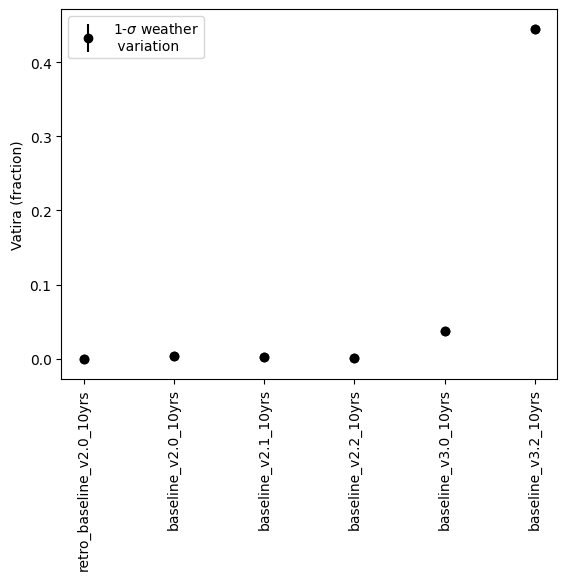

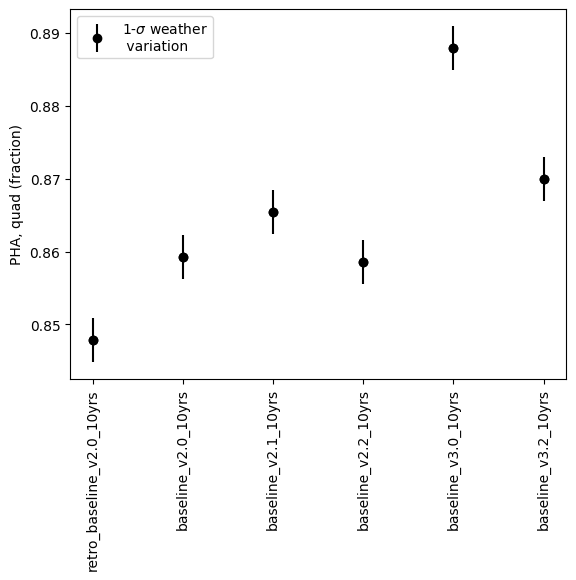

In [22]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_11046/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


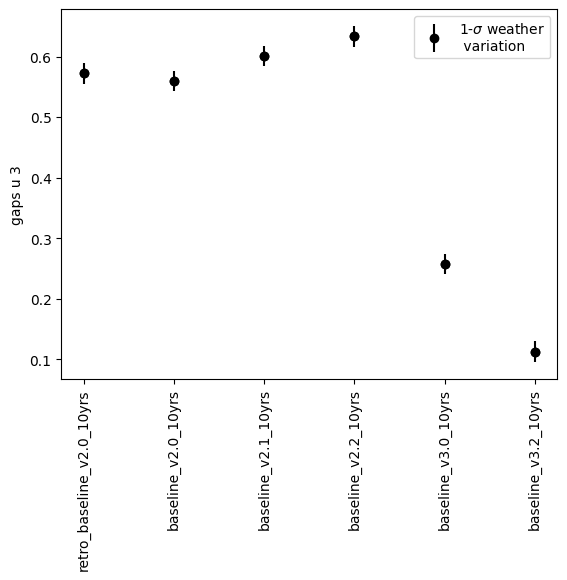

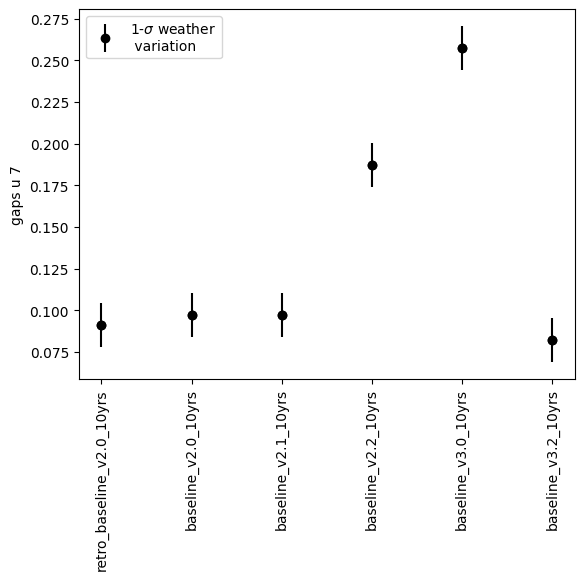

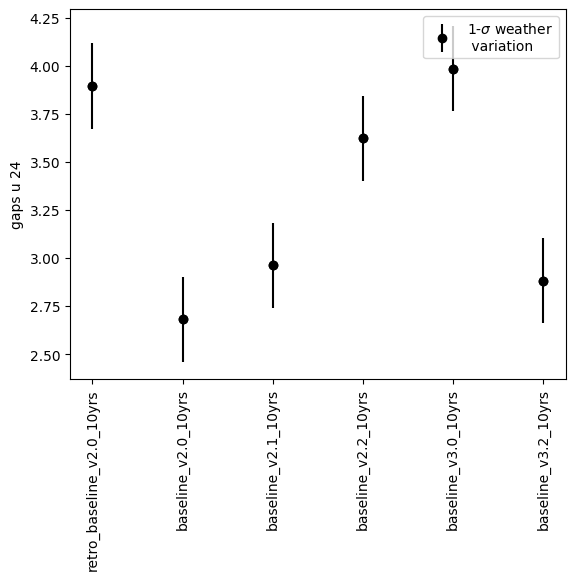

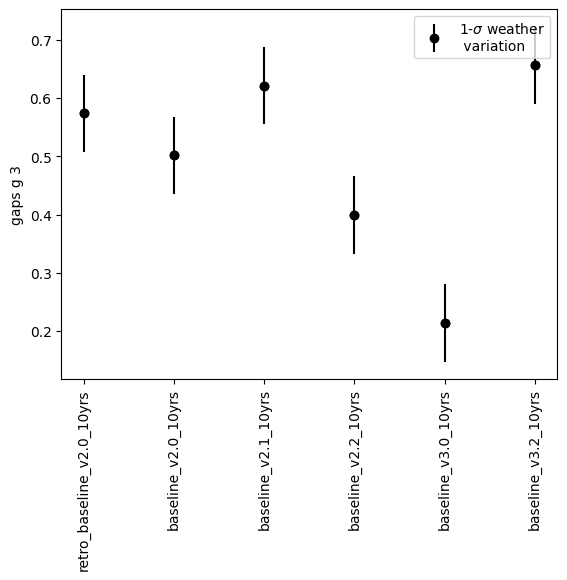

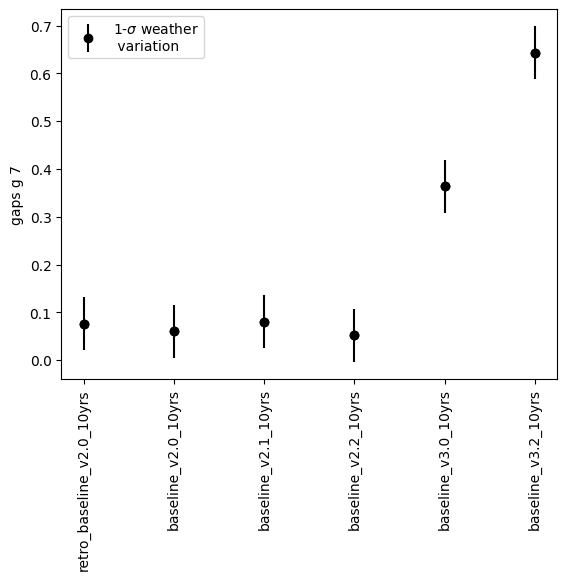

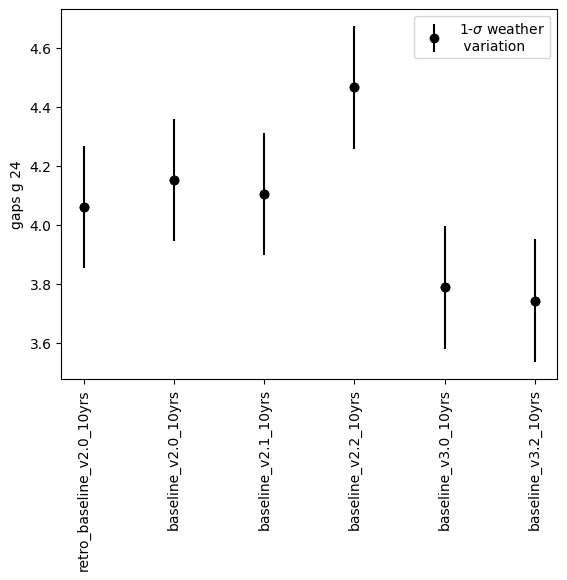

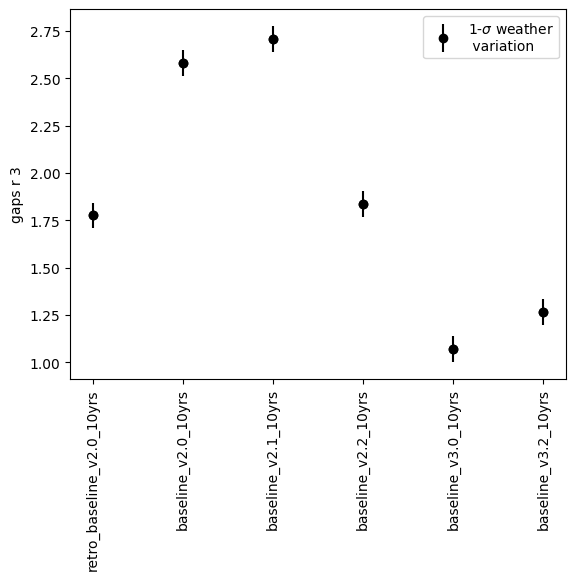

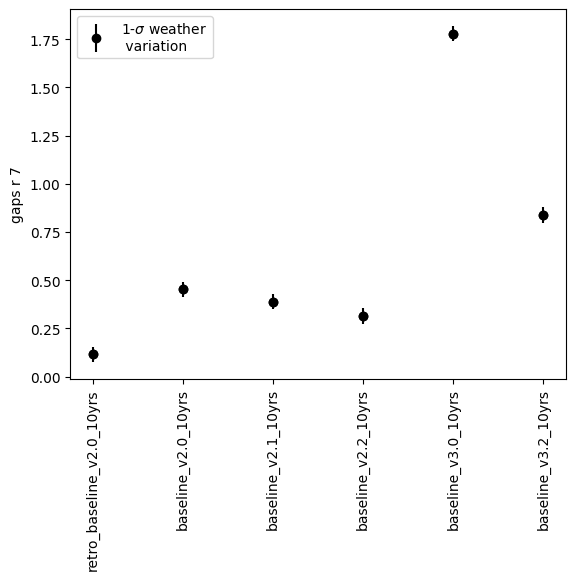

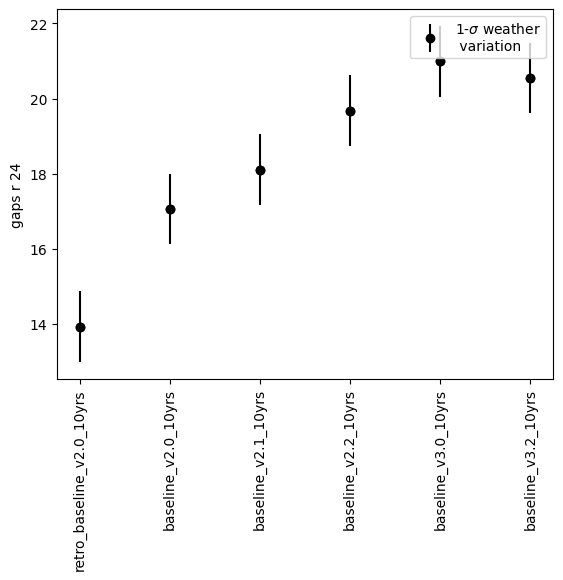

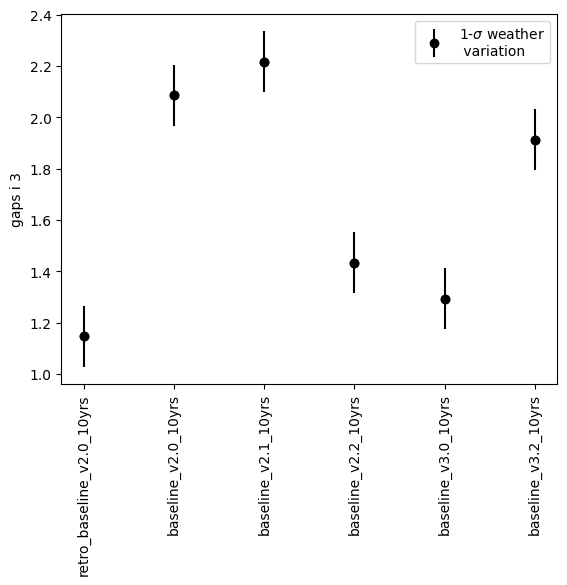

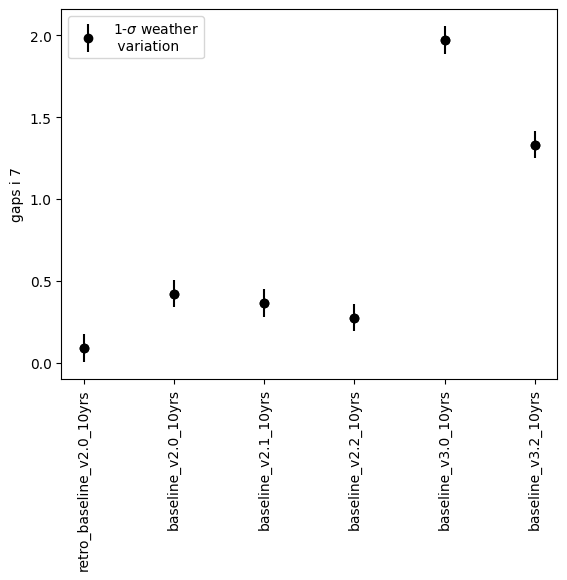

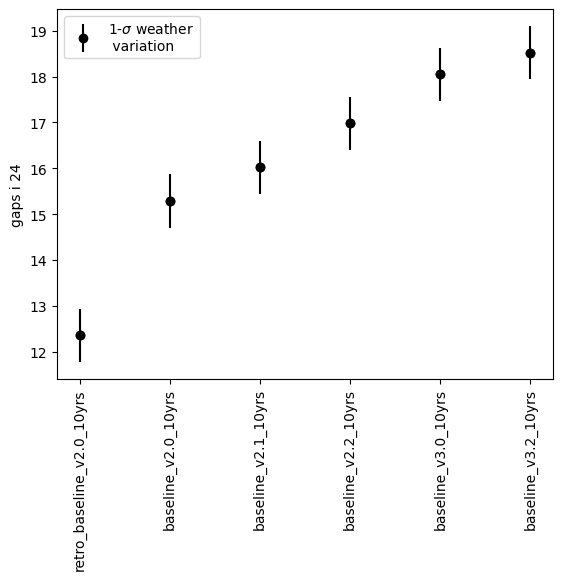

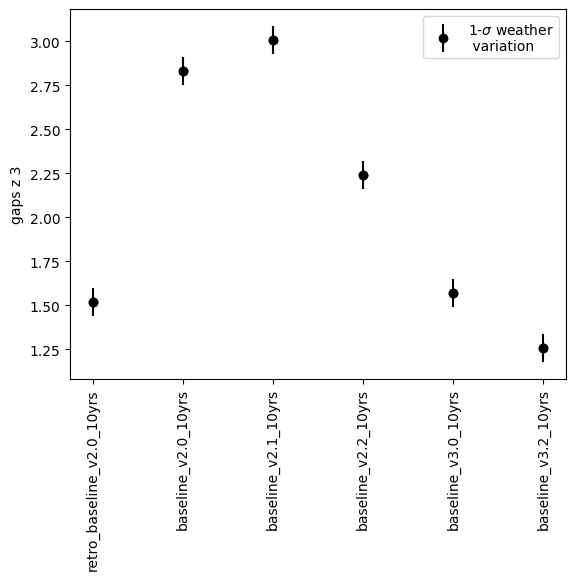

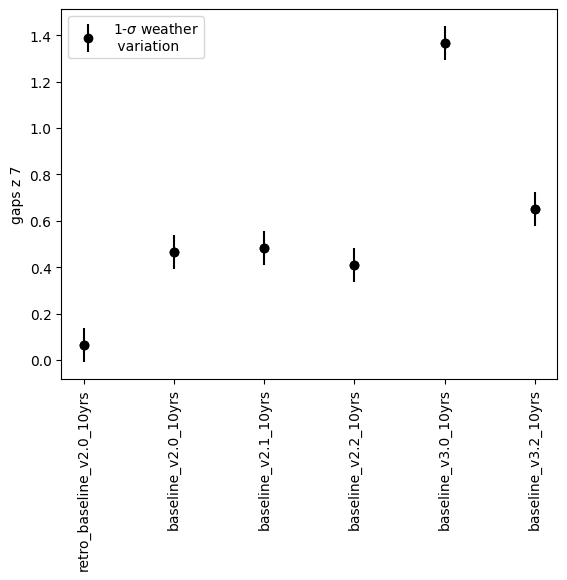

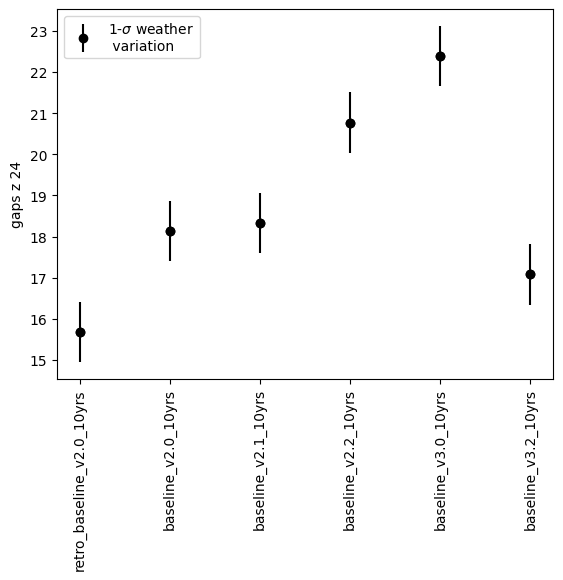

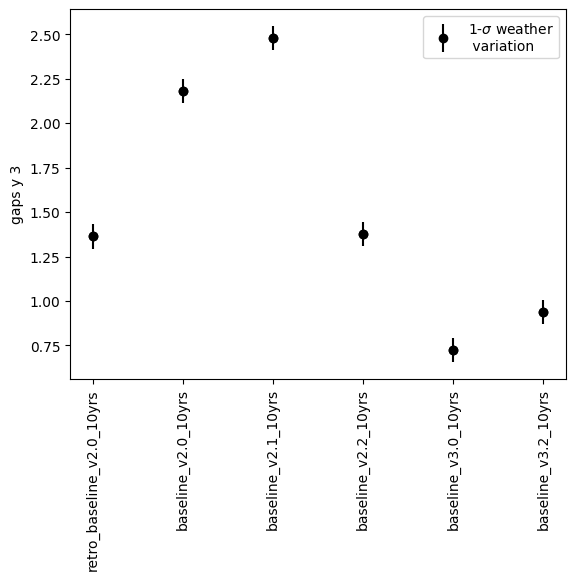

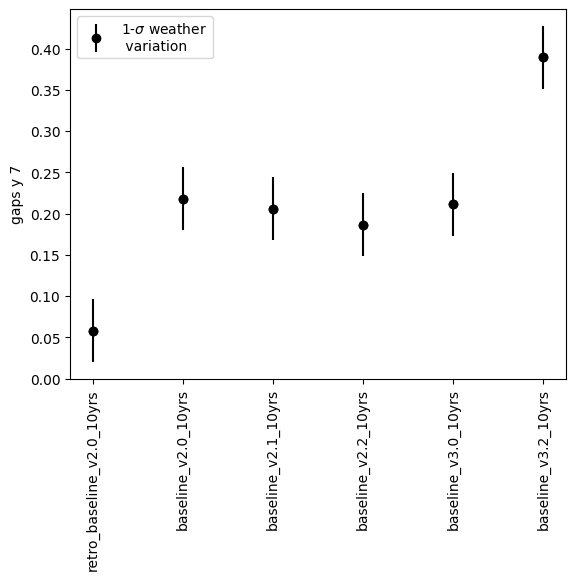

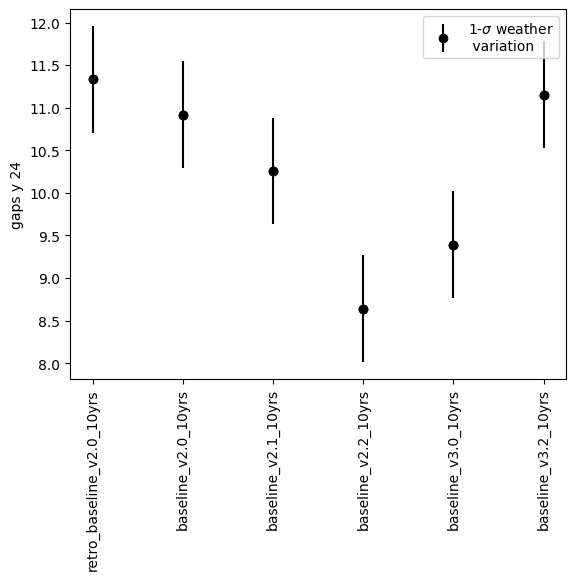

In [23]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


In [24]:
# so, we can think about what summary stats make the most sense for gaps. Might be top 18k sq degrees

In [25]:
times = ['baseline_v3.0_10yrs',  'baseline_v3.2_10yrs'] + [run for run in data.index if 'filter' in run and 'short' not in run]
sub_gaps = gaps_data.reindex(labels=times)


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_11046/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


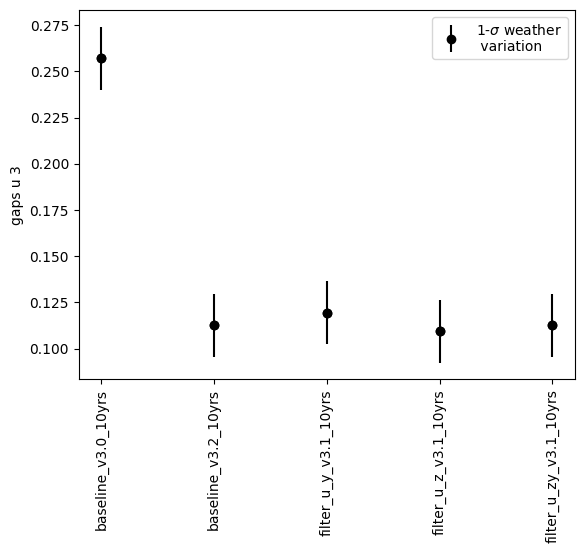

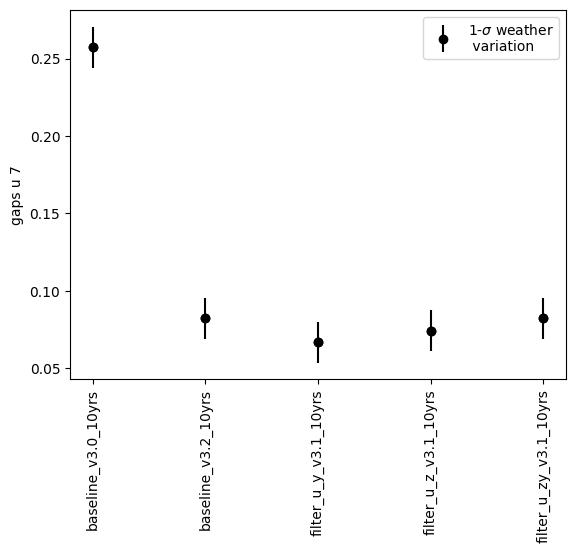

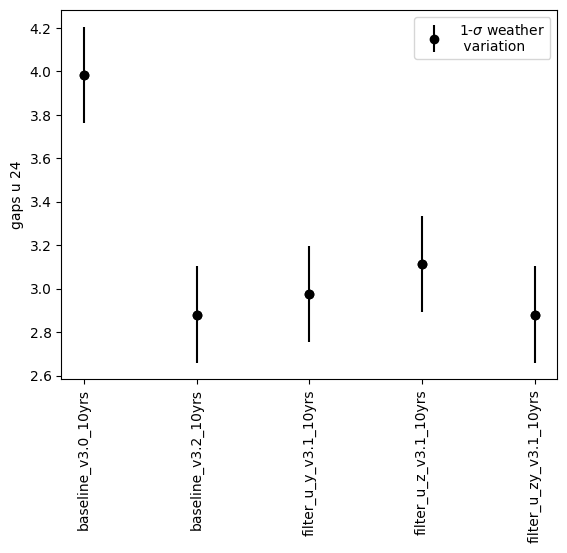

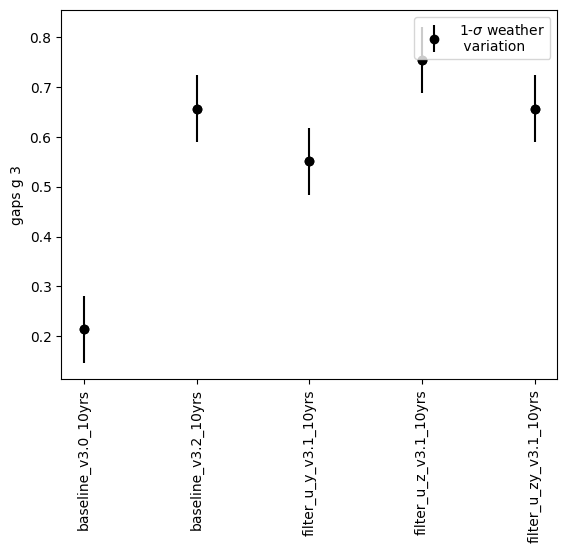

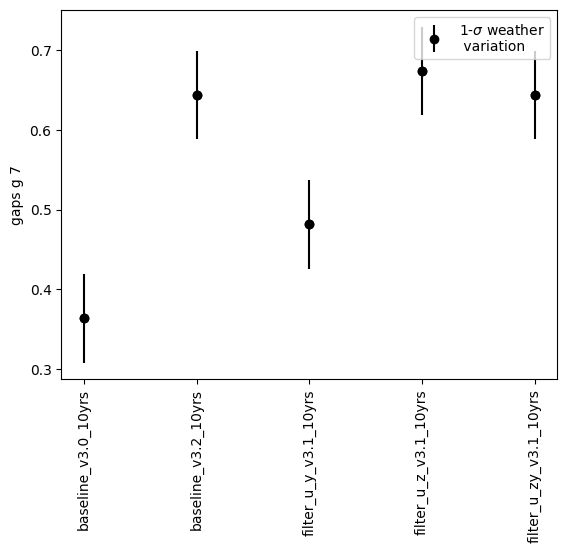

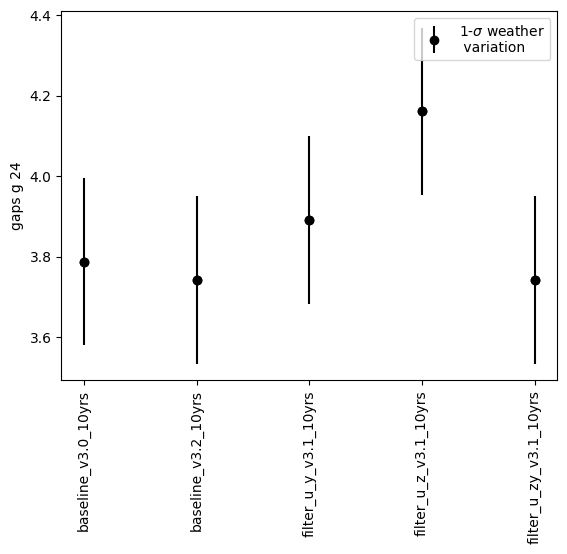

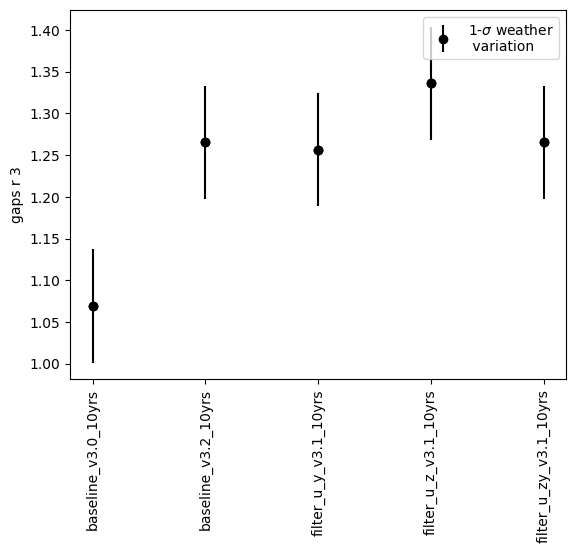

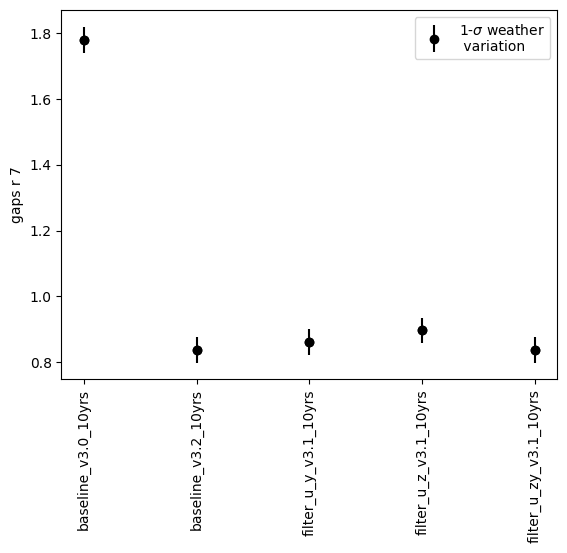

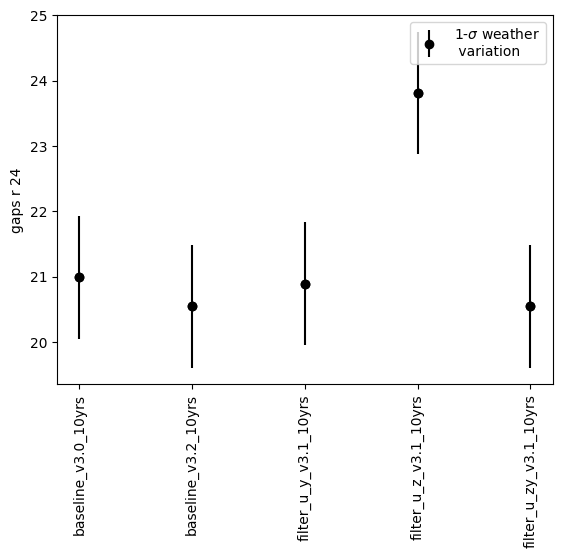

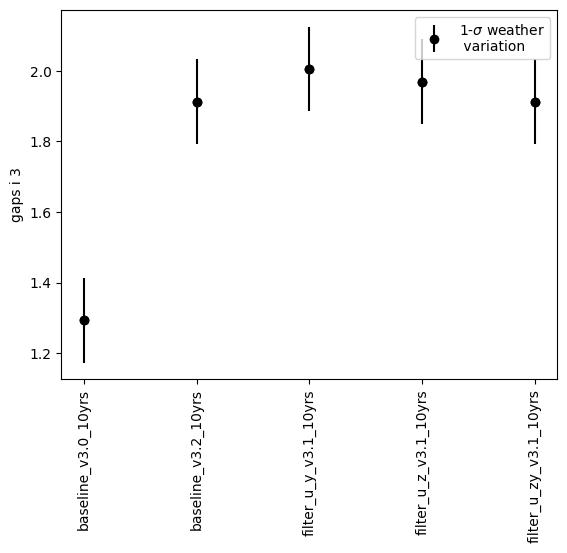

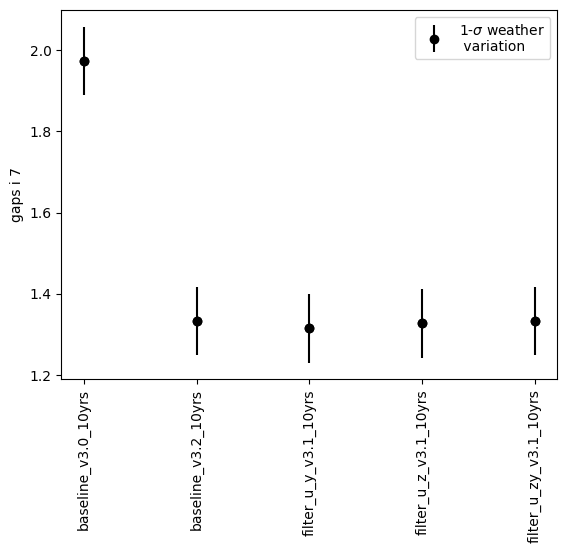

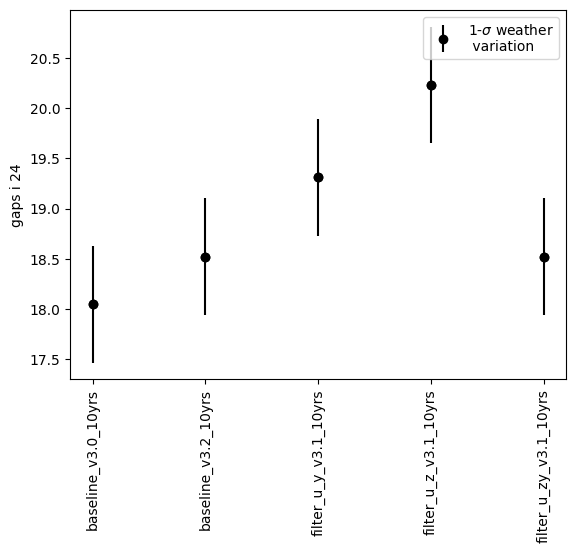

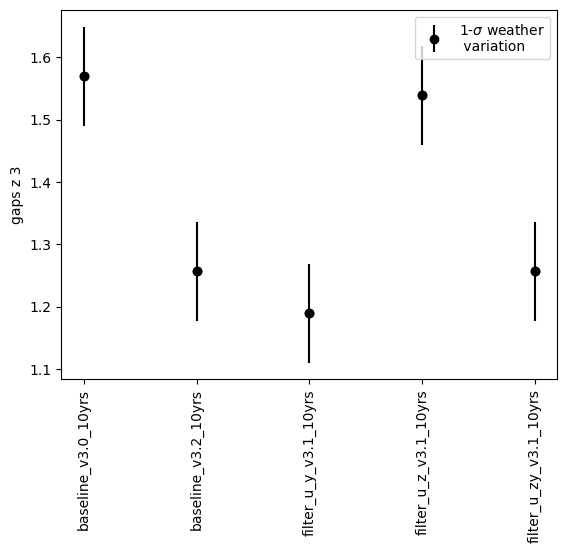

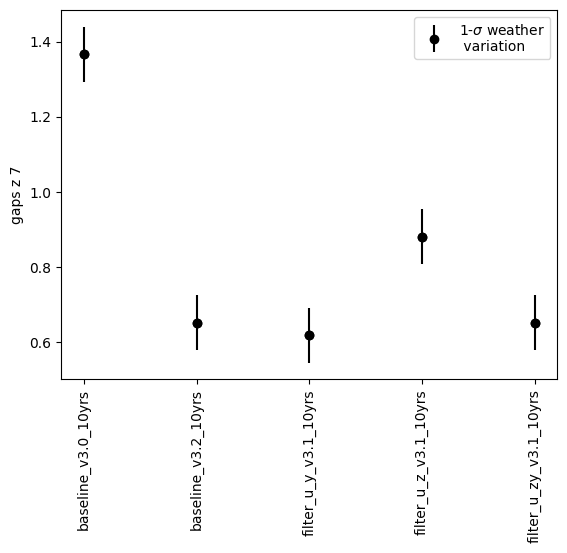

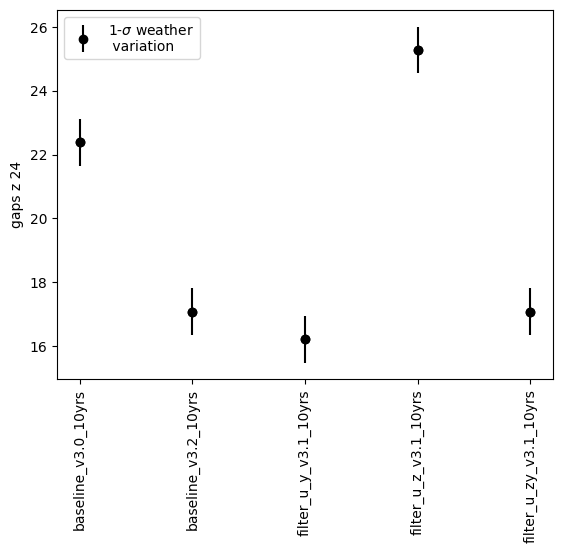

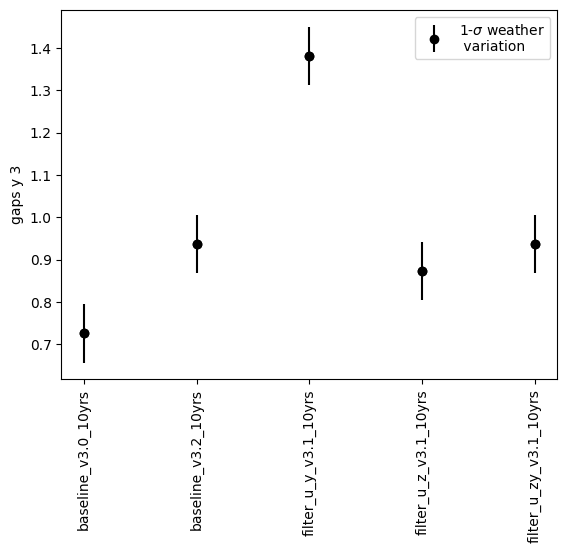

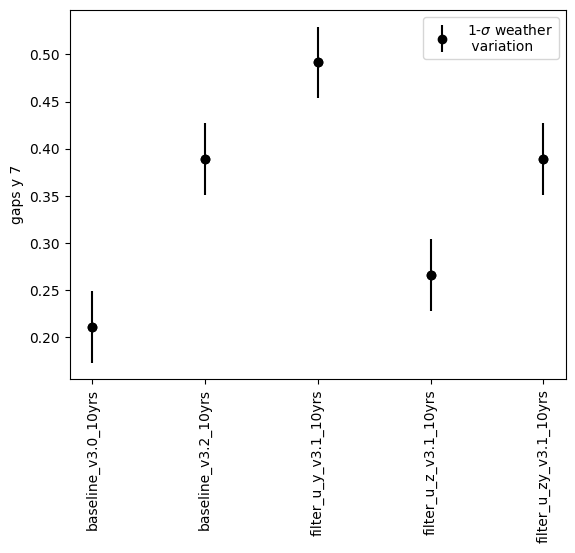

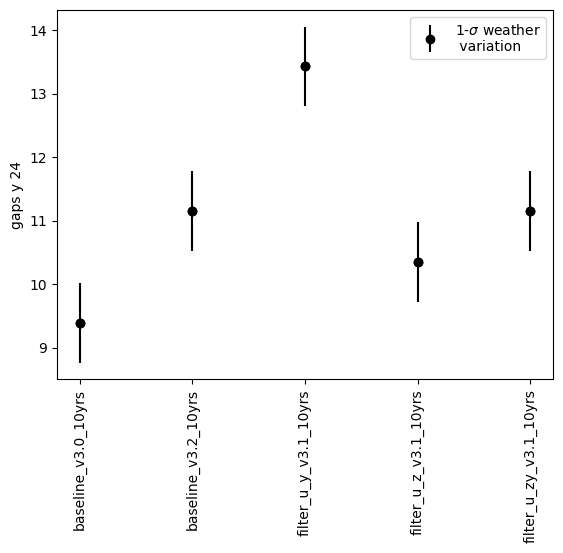

In [26]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_11046/526031158.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


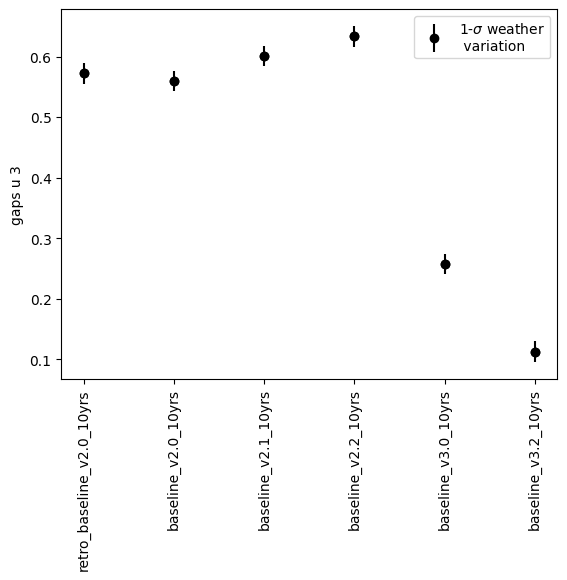

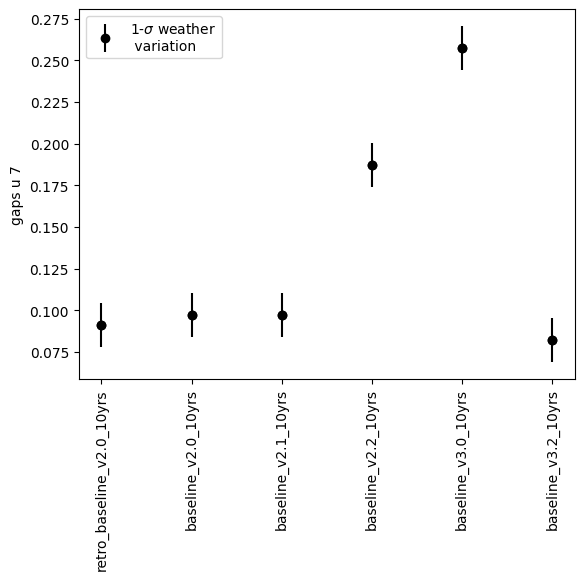

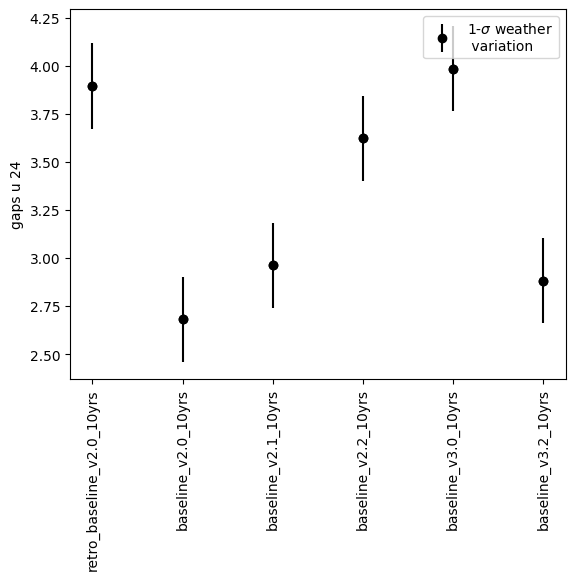

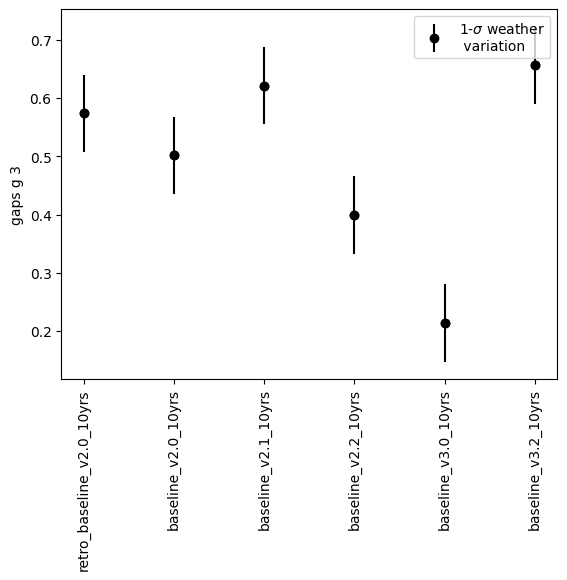

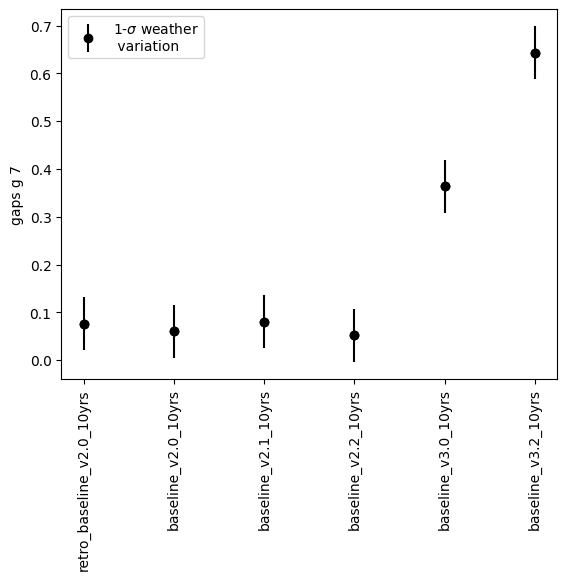

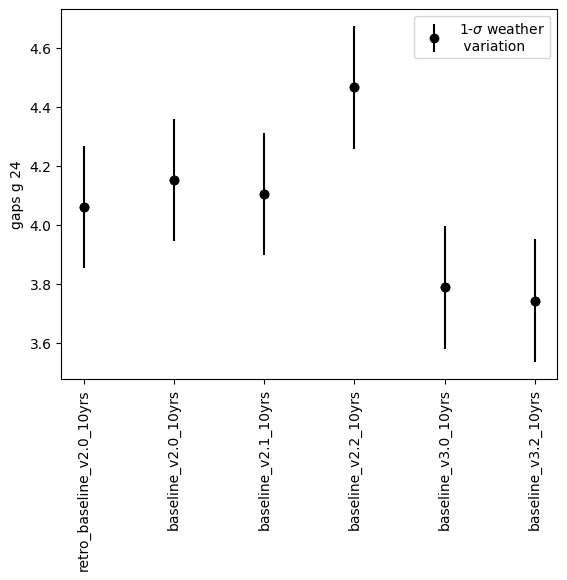

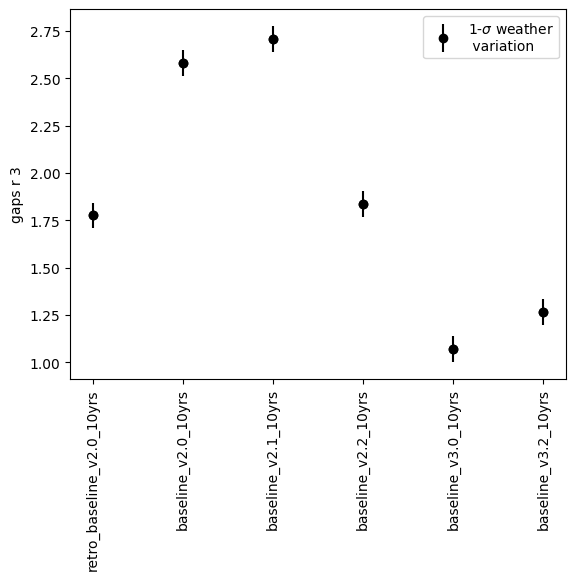

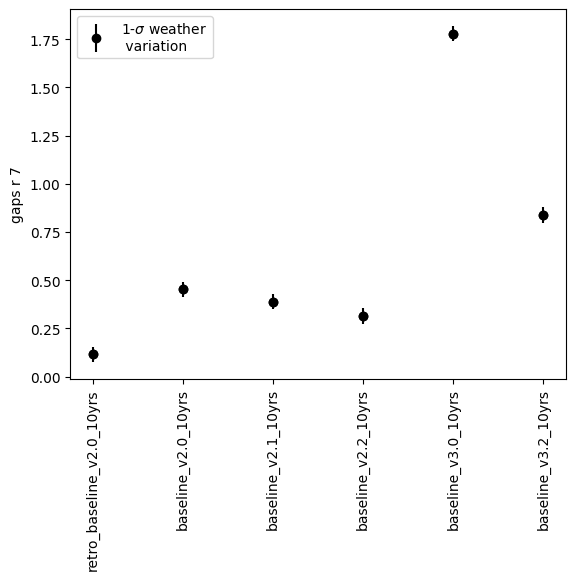

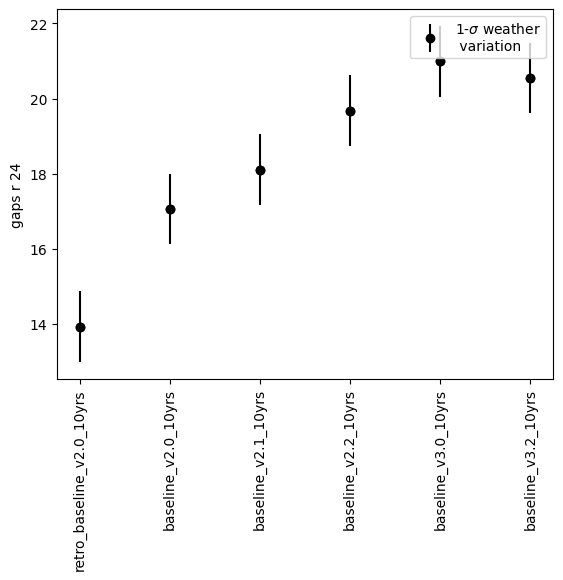

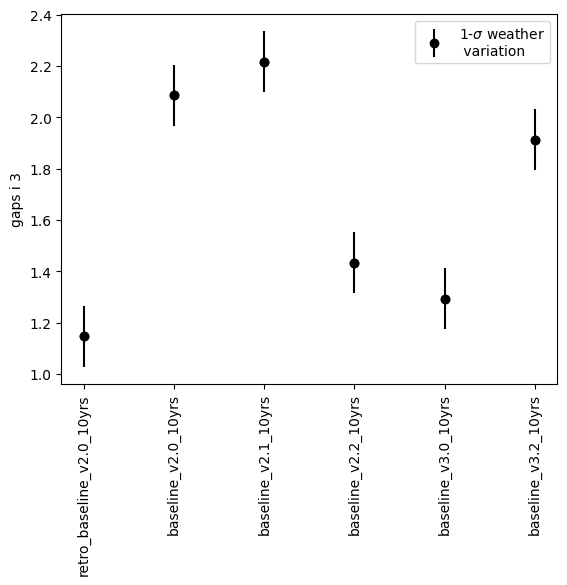

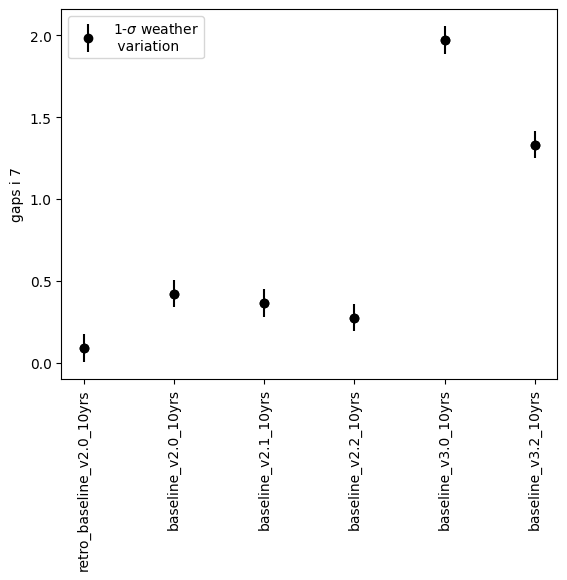

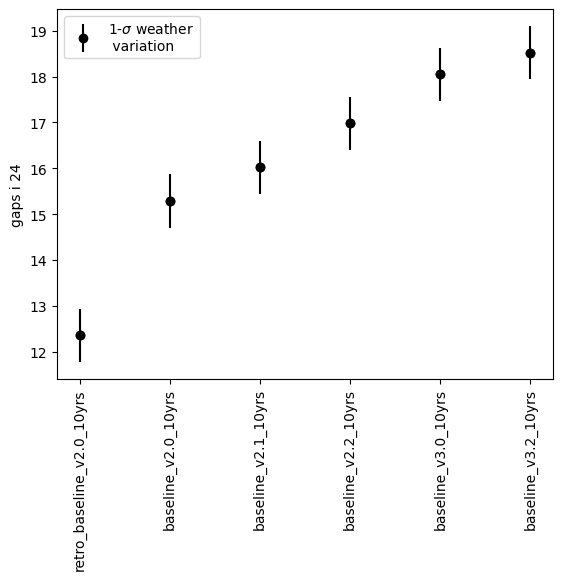

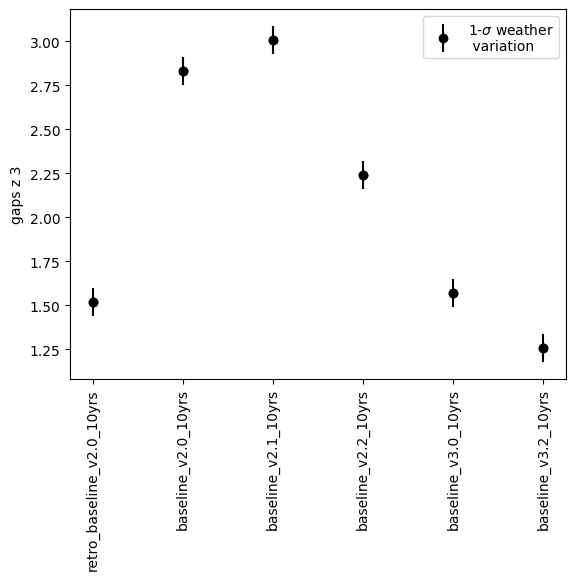

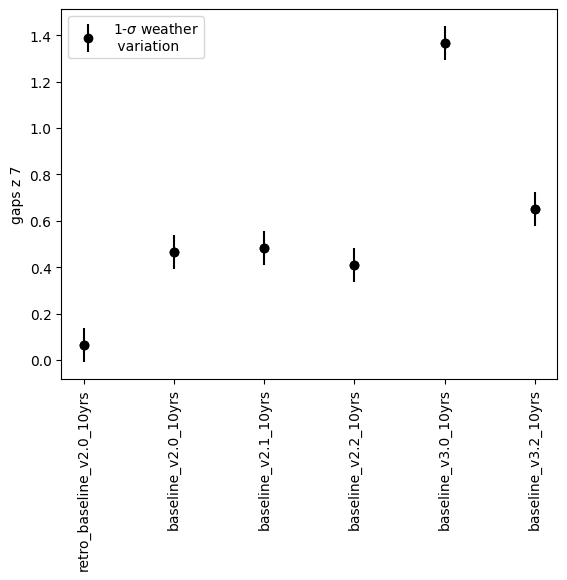

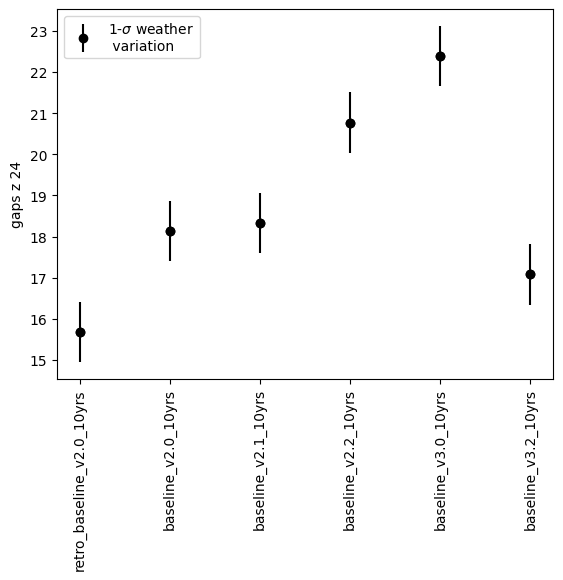

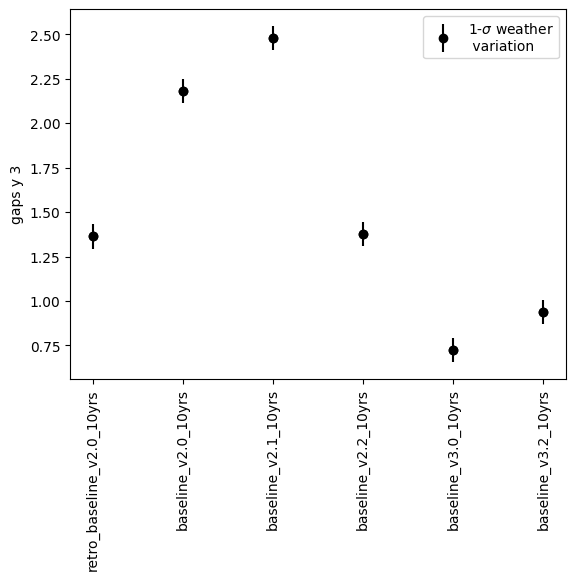

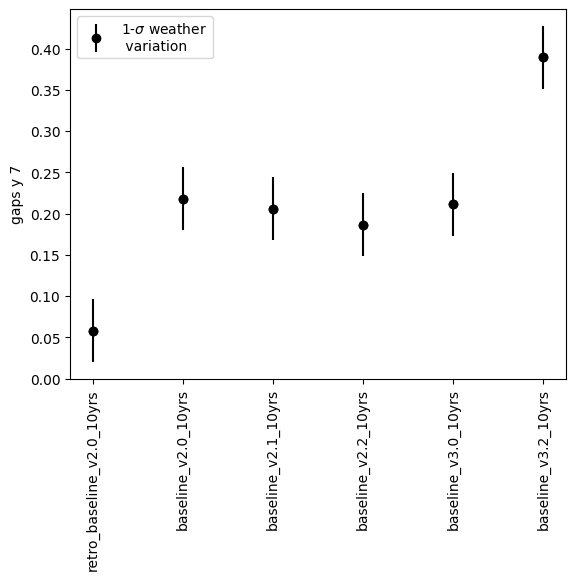

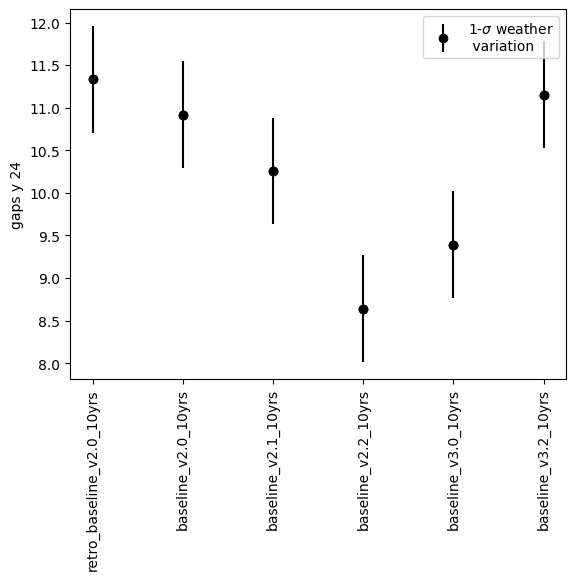

In [27]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs']

sub_gaps = gaps_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])